In [1]:
import pandas as pd
import altair as alt
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LsiModel, LdaMulticore
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
import string
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("drugLibTrain_raw.tsv", delimiter="\t",encoding='utf-8')
df_t = df.copy()

In [3]:
df.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


## Replacing Values
# To subdivide into 

In [6]:
rating_rating= [[1,2,3,4], [5,6],[7,8,9,10]]

for i, idx in enumerate(rating_rating):
    df['rating'].replace(to_replace=idx, value = i-1, inplace=True)

    
rating_effectiveness = [['Ineffective'], ['Marginally Effective','Moderately Effective'],
                        ['Considerably Effective','Highly Effective']]

for i, idx in enumerate(rating_effectiveness):
    df['effectiveness'].replace(to_replace=idx, value= i, inplace=True)

rating_sideEffects = [['No Side Effects'], ['Mild Side Effects', 'Moderate Side Effects'],
                      ['Severe Side Effects','Extremely Severe Side Effects']]

for i, idx in enumerate(rating_sideEffects):
    df['sideEffects'].replace(to_replace=idx, value= i, inplace=True)

## 1.Data Exploration/Data Description


1. What are the most top conditions/?
-> % frequency and average rating
2. Are text for the side effects longer?
-> for low medical  effectiveness and high side effects
3. Does the community has a more positive feeling?
4. Which is the most negative texts
-> Show some of the texts
Descriptive statitis 
overall rating
Distributon
Effictiveness
Sideeffects - >Verteilung anzahl un in Prozent
How many conditions
How many drugs?


In [9]:
rating_effectiveness = [['Ineffective'], ['Marginally Effective','Moderately Effective'], ['Considerably Effective','Highly Effective']]
list1 = ['Ineffective', 'Moderate Effect', 'Highly Effective']



df_t['effectiveness'].replace(to_replace=['Ineffective'], value= 'Ineffective', inplace=True)

df_t['effectiveness'].replace(to_replace=['Marginally Effective','Moderately Effective'], value= 'Moderate Effect', inplace=True)

df_t['effectiveness'].replace(to_replace=['Considerably Effective','Highly Effective'], value= 'Highly Effective', inplace=True)

rating_sideEffects = [['No Side Effects'], ['Mild Side Effects', 'Moderate Side Effects'],['Severe Side Effects','Extremely Severe Side Effects']]
list2 = ['No Sideeffects', 'Moderate Sideeffects','High SideEffects' ]

df_t['sideEffects'].replace(to_replace='No Side Effects', value= 'No Sideeffects', inplace=True)

df_t['sideEffects'].replace(to_replace=['Mild Side Effects', 'Moderate Side Effects'], value= 'Moderate Sideeffects', inplace=True)

df_t['sideEffects'].replace(to_replace=['Severe Side Effects','Extremely Severe Side Effects'], value= 'High SideEffects' ,inplace=True)

### Descriptive Statistics


### Data Description such as in paper

In [10]:
# How many rows on total
df_t.nunique()

# 3107 comments


Unnamed: 0           3107
urlDrugName           502
rating                 10
effectiveness           3
sideEffects             3
condition            1426
benefitsReview       3032
sideEffectsReview    2814
commentsReview       3047
dtype: int64

### SideEffects- Frequency

In [11]:
frequency_side = df_t.groupby('sideEffects')[['sideEffects']].count()
frequency_side['in %']= round(frequency_side['sideEffects']/frequency_side['sideEffects'].sum()*100,1)
frequency_side

,sideEffects,in %
sideEffects,,
High SideEffects,544,17.5
Moderate Sideeffects,1633,52.6
No Sideeffects,930,29.9


### Benefits-Frequency

In [12]:
frequency_benefit = df_t.groupby('effectiveness')[['effectiveness']].count()
frequency_benefit['in %']= round(frequency_benefit['effectiveness']/frequency_benefit['effectiveness'].sum()*100,1)
frequency_benefit

,effectiveness,in %
effectiveness,,
Highly Effective,2258,72.7
Ineffective,247,7.9
Moderate Effect,602,19.4


### Overall Rating Distributon

In [13]:
distribution = df_t.groupby('rating')[['effectiveness']].count()
distribution.reset_index(inplace= True)

In [14]:
distribution['in %']= round(distribution['effectiveness']/distribution['effectiveness'].sum()*100,1)
distribution

,rating,effectiveness,in %
0,1,305,9.8
1,2,103,3.3
2,3,146,4.7
3,4,107,3.4
4,5,159,5.1
5,6,157,5.1
6,7,350,11.3
7,8,558,18.0
8,9,480,15.4
9,10,742,23.9


### - Chart for overall distribution

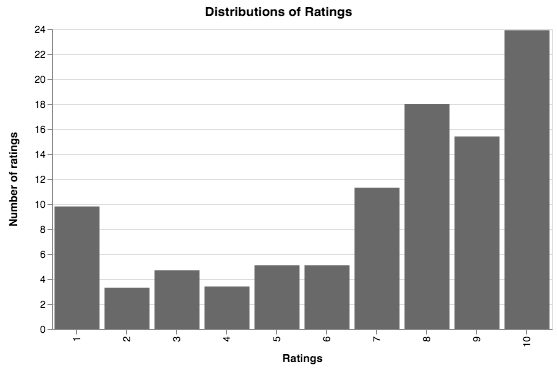

In [15]:
alt.Chart(distribution, title= 'Distributions of Ratings').mark_bar(color= 'dimgray').encode(
    alt.Y('in %:Q',axis=alt.Axis(title='Number of ratings')),
    alt.X('rating', type='nominal', axis=alt.Axis(title='Ratings'))
).properties(width= 500)





###  2. Are text for the side effects longer?
### -> for low medical  effectiveness and high side effects

### What about missing values?

In [16]:
# Check how many missing values exist within a total dataframe?
df_t.isnull().T.any().T.sum()
# -->df_t.isnull-> Shows all rows with true or false, 
# --> any-> shows the columns with missing values, is column based when applied on a dataframe
#What does the T stand for
# Make boolean mask of what kind of values are missing?
nan_rows = df_t[df_t.isnull().T.any().T]


### 3. What about the text length?

In [17]:
df_t['sideEffectsReview'].replace(np.nan,'', inplace= True)

# All mising data will be filled in
df_t.fillna('', inplace=True)

### -> Calculating the length column

In [18]:
# Add columns with the length of words in each sentiment  for both benefits => medical effectiveness and sideEffects--> sideEffectsreview


df_t['Length of Benefits Review']= df_t.apply(lambda row: len(row['benefitsReview']), axis=1)


df_t['Length of Side Effects Review']= df_t.apply(lambda row: len(row['sideEffectsReview']), axis=1)




### Text Lenght- Benefits

In [19]:
df_t['Length of Benefits Review'].mean()

207.25490827164467

In [20]:
df_t['Length of Side Effects Review'].mean()

179.3511425812681

In [21]:
text_length = df_t.groupby('sideEffects')[['Length of Side Effects Review']].mean()
text_length['Length of Side Effects Review']=round(text_length['Length of Side Effects Review'],1)
text_length

# Pick some of the most interesting data/comments

text_length_p = df_t.groupby('effectiveness')[['Length of Benefits Review']].mean()
text_length_p['Length of Benefits Review']= round(text_length_p['Length of Benefits Review'],1)
text_length_p

# What people write in this different categories

,Length of Benefits Review
effectiveness,
Highly Effective,224.4
Ineffective,132.7
Moderate Effect,173.6


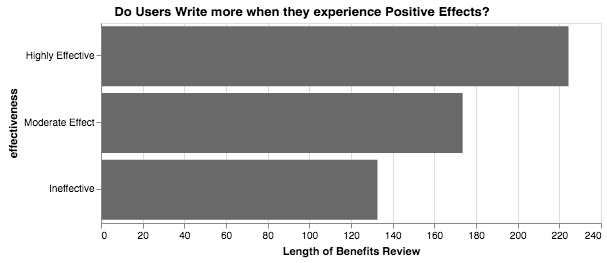

In [22]:
alt.Chart(text_length_p.reset_index(), title = 'Do Users Write more when they experience Positive Effects? ').mark_bar(color= 'dimgray').encode(
x= alt.X('Length of Benefits Review:Q'),
y= alt.Y('effectiveness:N',
        sort=alt.EncodingSortField(
            field="Length of Benefits Review",  
            op="sum",  
            order="descending"))).properties(width= 500, height=200)


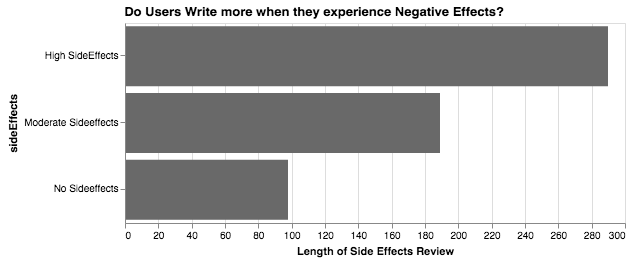

In [23]:
alt.Chart(text_length.reset_index(), title = 'Do Users Write more when they experience Negative Effects? ').mark_bar(color= 
                                                                                                                       'dimgray').encode(
x= alt.X('Length of Side Effects Review:Q'),
y= alt.Y('sideEffects:N')).properties(width= 500, height=200)



In [24]:
#
pd.set_option('display.max_colwidth', -1)

# Create a Boolean Mask for the Filering of :LENGHT >250 AND HIGH SIDE EFFECTS
a = df_t[(df_t['Length of Side Effects Review']>250) & (df_t['sideEffects']=='High SideEffects')]

# Show random selction of rows
a['sideEffectsReview'].sample(1)


476    in the past year i have been having reoccurring pink eye/blifuritis bouts.\r\r\naround the same tine i have been plagued with repeated episodes of itching, strange rashes all over my body and my hands are full of unsightly cracks,sores and redness. now the episodes are getting closer and closer and worse each time.
Name: sideEffectsReview, dtype: object

## Top 20 Drugs - Visualization in respect to the Frequency of side effects and effectiveness

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


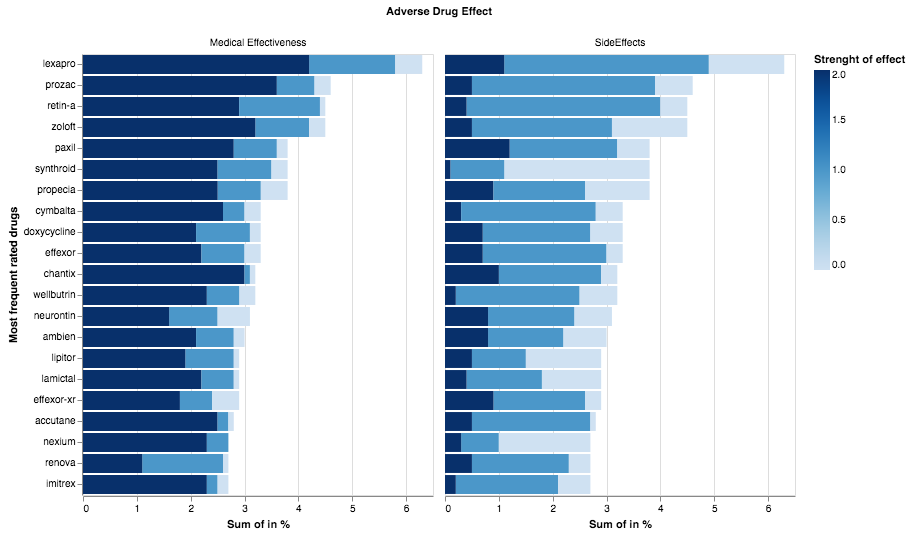

In [25]:

top20_drugs =df.groupby(['urlDrugName'])[['rating']].count().sort_values(by='rating', ascending= False)[:21]

index= list(top20_drugs.index)

df20 =df[df['urlDrugName'].isin(index) ]

df20.drop(columns=['Unnamed: 0','condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'], inplace = True)

df20.columns

df201 = df20.drop(columns='sideEffects')
df201['Adverse Drug Effect']= 'Medical Effectiveness'

df202 = df20.drop(columns='effectiveness')

df202.rename(columns = {'sideEffects':'effectiveness'}, inplace = True)
df202['Adverse Drug Effect']= 'SideEffects'

df203 = df201.append(df202)

df203['in %']= round((1/df203['rating'].count())*100,1)

df203.rename(columns={'urlDrugName':'Most frequent rated drugs','effectiveness':'Strenght of effect'}, inplace = True)

alt.Chart(df203).mark_bar().encode(
    column='Adverse Drug Effect',
    x='sum(in %):Q',
    y=alt.Y('Most frequent rated drugs', sort=alt.EncodingSortField(field="Most frequent rated drugs", op="count", order='descending')),
    color='Strenght of effect'
).properties(width=350)





## Top 20 Conditions - Visualization in respect to the Frequency of side effects and effectiveness

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


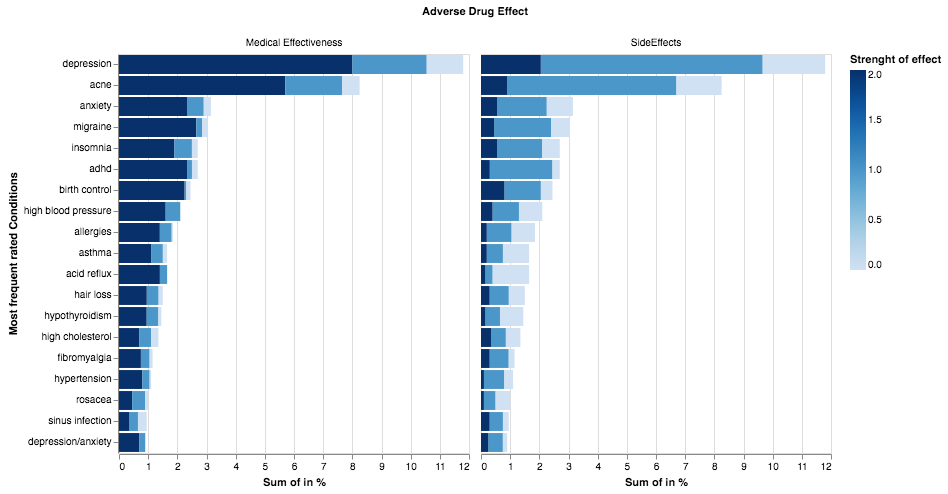

In [26]:
top20_conditions =df.groupby(['condition'])[['rating']].count().sort_values(by='rating', ascending= False)[:21]

index= list(top20_conditions.index)

df_20 =df[df['condition'].isin(index) ]

df_20.drop(columns=['Unnamed: 0','urlDrugName', 'benefitsReview', 'sideEffectsReview', 'commentsReview'], inplace = True)

df_20.columns

df_201 = df_20.drop(columns='sideEffects')
df_201['Adverse Drug Effect']= 'Medical Effectiveness'

df_202 = df_20.drop(columns='effectiveness')

df_202.rename(columns = {'sideEffects':'effectiveness'}, inplace = True)
df_202['Adverse Drug Effect']= 'SideEffects'

df_203 = df_201.append(df_202)

df_203.head()

df_203.rename(columns={'condition':'Most frequent rated Conditions','effectiveness':'Strenght of effect'}, inplace = True)

df_203['in %']= round((1/df_203['rating'].count())*100,1)


df_203['Most frequent rated Conditions'].replace('migraines','migraine', inplace = True)
df_203['Most frequent rated Conditions'].replace('add','adhd', inplace = True)
df_203['in %']= round((1/df_203['rating'].count())*100,2)

alt.Chart(df_203).mark_bar().encode(
    column='Adverse Drug Effect',
    x='sum(in %):Q',
    y=alt.Y('Most frequent rated Conditions', sort=alt.EncodingSortField(field="Most frequent rated Conditions", op="count", order='descending')),
    color='Strenght of effect'
).properties(width=350)

## New Descriptive Statistics

1. What are the most top conditions/?
-> % frequency and average rating
2. Are text for the side effects longer?
-> for low medical  effectiveness and high side effects
3. Does the community has a more positive feeling?
4. Which is the most negative texts
-> Show some of the texts
Descriptive statitis 
overall rating
Distributon
Effictiveness
Sideeffects - >Verteilung anzahl un in Prozent
How many conditions
How many drugs?




In [27]:
df_t.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,Length of Benefits Review,Length of Side Effects Review
0,2202,enalapril,4,Highly Effective,Moderate Sideeffects,management of congestive heart failure,slowed the progression of left ventricular dysfunction into overt heart failure \r\r\nalone or with other agents in the managment of hypertension \r\r\nmangagement of congestive heart failur,"cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness","monitor blood pressure , weight and asses for resolution of fluid",184,197
1,3117,ortho-tri-cyclen,1,Highly Effective,High SideEffects,birth prevention,"Although this type of birth control has more cons than pros, it did help with my cramps. It's also effective with the prevention of pregnancy. (Along with use of condoms as well)","Heavy Cycle, Cramps, Hot Flashes, Fatigue, Long Lasting Cycles. It's only been 5 1/2 months, but i'm concidering changing to a different bc. This is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.","I Hate This Birth Control, I Would Not Suggest This To Anyone.",178,258
2,1146,ponstel,10,Highly Effective,No Sideeffects,menstrual cramps,"I was used to having cramps so badly that they would leave me balled up in bed for at least 2 days. The Ponstel doesn't take the pain away completely, but takes the edge off so much that normal activities were possible. Definitely a miracle medication!!",Heavier bleeding and clotting than normal.,"I took 2 pills at the onset of my menstrual cramps and then every 8-12 hours took 1 pill as needed for about 3-4 days until cramps were over. If cramps are bad, make sure to take every 8 hours on the dot because the medication stops working suddenly and unfortunately takes about an hour to an hour and a half to kick back in.. if cramps are only moderate, taking every 12 hours is okay.",254,42
3,3947,prilosec,3,Moderate Effect,Moderate Sideeffects,acid reflux,"The acid reflux went away for a few months after just a few days of being on the drug. The heartburn started again as soon as I stopped taking it. So I began treatment again. 6 months passed and I stopped taking it. The heartburn came back, and seemed worse even. The doctor said I should try another 6 month treatment. I did, and the same exact thing happened. This went on for about three years. I asked why this wasn't curing my reflux. The doctor quite frankly told me that it wasn't a cure, but a ""treatment for the symptoms"". I was told that I would probably be on it for the rest of my life.","Constipation, dry mouth and some mild dizziness that would go away after medication was stopped for a few days.","I was given Prilosec prescription at a dose of 45mg per day. Medication was taken once, every morning before eating. Each treatment duration was for 6 months.",598,111
4,1951,lyrica,2,Moderate Effect,High SideEffects,fibromyalgia,"I think that the Lyrica was starting to help with the pain, but the side-effects were just too severe to continue.",I felt extremely drugged and dopey. Could not drive at all while on this med. Also had extreme ankle and feet swelling and couldn't even wear shoes.,See above,114,150


### Creating a new column - combing all the features

In [28]:
df_t['review']=(df_t['benefitsReview']+df_t['sideEffectsReview']+df_t['commentsReview'])
df_t['Length of Review']= df_t.apply(lambda row: len(row['review']), axis=1)


In [29]:
analyser = SentimentIntensityAnalyzer()


df_t['review1'] = df_t['review'].apply(analyser.polarity_scores)

df_t['review-list']=df_t['review1'].apply(lambda x: x.values())

df_t2 =df_t['review-list']

df_t2 =pd.DataFrame(df_t2.tolist(), columns=['VAD_neg', 'VAD_neu', 'VADpos', 'VAD_compound'])

In [30]:
df_t4 = pd.merge(df_t, df_t2, left_index=True, right_index=True)

### CSV-Creation After Merge of Vader-Data

In [31]:
df_t4.to_csv('DL_1_Vader_Merge.csv')